In [1]:
##** must be installed locally /usr/local/bin/mkdssp, not in your conda env ***
!which mkdssp
#!mkdssp  2DKE_edit.pdb

/usr/local/bin/mkdssp


In [2]:
model_path = '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4_adapterslibrary/'
out_path = '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES+ATTENTION_ANALYSIS/pdbs_only_correctly_predicted/temberture'
data_path ='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/AA_ENRICHMENT_VS_HAS/pdbs_data_only_correct_one/'
#!cd  '/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/ANALYSIS/SASA_SCORE_DISULFIDEBONDS_SALTBRIDGES/pdbs_only_correctly_predicted'
!mkdir img

mkdir: cannot create directory ‘img’: File exists


In [3]:
### example
#1. using class
#from temBERTure.temBERTure import TemBERTure
#classifier = TemBERTure(adapter_path='/ibmm_data/TemBERTure/model/BERT_cls/BEST_MODEL/lr_1e-5_headropout01/output/best_model_epoch4 (copy)/',task='classification',device='cuda:3')
#classifier.predict([pdb_thermo['COMPLETE_SEQ'][15]])
#2. transformers pipeline
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline("text-classification",model=model_classification,tokenizer='Rostlab/prot_bert_bfd')

In [4]:
# SASA
#https://biopython.org/docs/dev/api/Bio.PDB.SASA.html
#https://www.google.com/search?q=SASA+protein&sxsrf=ALiCzsYMW3POZZINcRQsZX66P4GoJSROnw:1669881805788&source=lnms&tbm=isch&sa=X&ved=2ahUKEwju7ua--tf7AhUei_0HHUWeDeMQ_AUoAXoECAEQAw&biw=1990&bih=1020&dpr=1.25#imgrc=uMFPC-SOr8m9jM
#it gives me the score of exposion, circa 0 in the core since it is not expose and higher and higher more the area is expose
# check if it is a discrimination in both sense

## *** UPDATE 06/02/2022 ******
#Use DSSP (with Biopython) to extract the relative solvent accessibility (RSA) [index 3 in the output tuple]
#https://biopython.org/docs/1.75/api/Bio.PDB.DSSP.html
#Let's define buried residue as any residue with a RSA < 25%
#https://www.biostars.org/p/9481863/
#wE should just extract the ACC column
#This is the absolute value, which you should divide by:
'''normalizing_values={'A' : 106,
'C' : 135,
'D' : 163,
'E' : 194,
'F' : 197,
'G' : 84,
'H' : 184,
'I' : 169,
'K' : 205,
'L' : 164,
'M' : 188,
'N' : 157,
'P' : 136,
'Q' : 198,
'R' : 248,
'S' : 130,
'T' : 142,
'V' : 142,
'W' : 227,
'Y' : 222}'''
# normalizing values from  https://www.biostars.org/p/9518409/#9518448
# DSSP TERMINAL COMMAND: dssp -i 1hl9.pdb -o 1hl9.dssp
# however biopython facilitates things by returning with index 3 in the tuple the already normalized sasa score values ( ACC COLUMN IN THE .DDSP DIVIDED BY THE MAXIMUM VALUES PER AMINO ACID)
# Example:
'''from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
import prody
#from sh import gunzip

#pdb = prody.parsePDB('1hl9',chain='A')

#gunzip('1hl9.pdb.gz')
parser = PDBParser()
io = PDBIO()
structure = parser.get_structure('X', '1hl9_edit.pdb') #using the pdb edited by prody to fix the structure and reading only the interested chain
model = structure[0]
dssp = DSSP(model, '1hl9_edit.pdb', dssp="dssp") #dssp='mkdssp'
dssp_out = list(dssp)
chain_dss= [lis for lis in dssp_out if lis]
res_name = [lis[1] for lis in dssp_out]
sasa_score = [lis[3] for lis in dssp_out]
res_name'''

## UPDATE 28/03
# DONE --> SASA could you plot the SASA score on a few PDB and see if the threshold between exposed and surfaces makes sense? We might have to increase the threshold or add a third level (e.g. expose, semi buried, core).
#for the high E, D, K, H and R, could you check if they form salt-bridges:
#http://www.ks.uiuc.edu/Research/vmd/plugins/saltbr/

## update 18/04
# add the extraction of disulfide bonds as well as we did for saltbridge using biotite library
## code from https://www.biotite-python.org/examples/gallery/structure/disulfide_bonds.html

## update 10/05
#add the category of aa types, this is an aggregate analisys in aa categories

## update
## perform a significance test, fisher exact test, on both single aa and aa types, meso and thermo separately
#The two categories are: Exposed vs Buried and High vs Low

'from Bio.PDB import *\nfrom Bio.PDB.DSSP import DSSP\nimport prody\n#from sh import gunzip\n\n#pdb = prody.parsePDB(\'1hl9\',chain=\'A\')\n\n#gunzip(\'1hl9.pdb.gz\')\nparser = PDBParser()\nio = PDBIO()\nstructure = parser.get_structure(\'X\', \'1hl9_edit.pdb\') #using the pdb edited by prody to fix the structure and reading only the interested chain\nmodel = structure[0]\ndssp = DSSP(model, \'1hl9_edit.pdb\', dssp="dssp") #dssp=\'mkdssp\'\ndssp_out = list(dssp)\nchain_dss= [lis for lis in dssp_out if lis]\nres_name = [lis[1] for lis in dssp_out]\nsasa_score = [lis[3] for lis in dssp_out]\nres_name'

# Notebook Prep

In [5]:
# General Libraries
import re
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import matplotlib

# Notebook Libraries
import math
from transformers import BertTokenizer, BertModel
from adapters import  BertAdapterModel
import torch
import torch.nn as nn
from transformers.modeling_utils import PreTrainedModel , PretrainedConfig

# CLS MODEL

In [6]:
# to import the code 
import sys
sys.path.insert(0, '/ibmm_data/TemBERTure/model/code/') 
from temBERTure.temBERTure import TemBERTure
classifier = TemBERTure(adapter_path= model_path ,task='classification',device='cuda:3')
#classifier.predict([pdb_meso['COMPLETE_SEQ'][3]])
from analysis.sasa_utils import *

In [8]:
## ** DO NOT USE : SEEMS THAT PIPELINE GIVES ONLY SOMETIMES AN ERROR LABEL AND SCORE **
#model_classification=TemBERTure_for_classification(model_path) # to compute classification score
#from transformers import pipeline
#pipe = pipeline(model=model_classification,tokenizer='Rostlab/prot_bert_bfd')
#pipe(pdb_meso['COMPLETE_SEQ'][3].replace('',' ')) # it gives you only label 0 also if is a thermophilic because he is a binary classification

# RAW DATA

In [9]:
path=data_path

## PDB THERMO (only correctly predicted)

In [10]:
# THERMO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
#pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo=pd.read_csv(path+'pdbs_thermo_cls_corr_predicted',header=None,sep=',')
pdb_thermo.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_thermo

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,1IN4_A,QFLRPKSLDEFIGQENVKKKLSLALEAAKMRGEVLDHVLLAGPPGL...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.930360
1,2Z1E_A,AGGEIMEELLRDVILKTLTLKSAGGIGLDALDDGATIPFGDKHIVF...,[1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. ...,1,0.999735
2,1TML_A,NDSPFYVNPNMSSAEWVRNNPNDPRTPVIRDRIASVPQGTWFAHHN...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.564142
3,1TWL_A,NPFHDLEPGPDVPEVVYAIIEIPKGSRNKYELDKKTGLLKLDRVLY...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999206
4,1IDM_A,MKVAVLPGDGIGPEVTEAALKVLRALDEAEGLGLAYEVFPFGGAAI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999226
5,1Y6J_A,RSKVAIIGAGFVGASAAFTMALRQTANELVLIDVFKEKAIGEAMDI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.832106
6,1EPZ_A,EFRFIKTSLDGAIIIEPEVYTDERGYFMETFNEAIFQENGLEVRFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.631386
7,1RIY_A,MNKKELIDRVAKKAGAKKKDVKLILDTILETITEALAKGEKIQIVG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.997698
8,5ZX8_A,MFLVVGQGNPGERYARTRHNLGFMVLDRLGLSFRPRGEALVAEAEG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.999947
9,1VLV_A,MSVNLKGRSLLTLLDFSPEEIRYLLDISKQVKMENRSKLRTERFKG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,1,0.972860


In [11]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#results = pdb_thermo['COMPLETE_SEQ'].str.replace('',' ').apply(lambda x: pipe(x))

# Extract 'label' and 'score' values into separate columns
#pdb_thermo['label'] = [0 if result[0]['score'] <=0.5 else 1 for result in results]
#pdb_thermo['score'] = [result[0]['score'] for result in results]
#pdb_thermo

## PDB MESO (only correctly predicted)

In [12]:
# MESO PDB
# run the model on complete_seq and plot in the .pdb only the amino acid with mask 1
pdb_meso=pd.read_csv(path+'pdbs_meso_cls_corr_predicted',header=None,sep=',')
pdb_meso.columns=['PDB_ID','COMPLETE_SEQ','SEQ_MASK','LABEL','CLS_SCORE']
pdb_meso

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,6BLB_A,AIRPLKLADYIGQPSVREQMELFIHAARGRQEALDHTLIFGPPGLG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.003616
1,2Z1U_A,TLLLDYGSGGRASHRLISDLFLRHFDNPILGTLNDAARLDLTGPLA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.218385
2,1UP0_A,ANPLAGKPFYVDPASAAMVAARNANPPNAELTSVANTPQSYWLDQA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.026884
3,6K21_A,SYNNIPAGKDAPNDIYVIIEIPANAAPIKYEIDKDSDALFVDRFMG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002263
4,3VML_A,SSYQIAVLAGDGIGPEVMAEARKVLKAVEARFGLNIEYTEYDVGGI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.001266
5,1LLC_A,ASITDKDHQKVILVGDGAVGSSYAFAMVLQGIAQEIGIVDIFKDKT...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.016418
6,1RTV_A,MKATRLAIPDVILFEPRVFGDDRGFFFESYNQRAFEEACGHPVSFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.193056
7,4P3V_A,MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002748
8,2Z2I_A,MAEPLLVVGLGNPGANYARTRHNLGFVVADLLAARLGAKFKAHKRS...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.007980
9,1DXH_A,AFNMHNRNLLSLMHHSTRELRYLLDLSRDLKRAKYTGTEQQHLKRK...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.070078


In [13]:
### ** COMPUTE THE CLS LABEL AND SCORE **, NOT NECESSARY ANYMORE SINCE WE HAVE ALREADY THIS INFO IN THE DATA
# Apply the pipeline to each row in the 'COMPLETE_SEQ' column
#preds = pdb_meso['COMPLETE_SEQ'].apply(lambda x: classifier.predict([x]))

# Extract 'label' and 'score' values into separate columns
#pdb_meso['label'] = [int(p[0]) for p in preds]
#pdb_meso['score'] = [float(p[1]) for p in preds]

## PDBS PAIRS DATA

In [14]:
pairs = pd.read_csv('/data/TemBERTure/ANALYSIS/Enriched_PDB_data/TEST/FinalPairs',sep=',',header=0)
pairs

,ThermoIds,Non_thermoIds
0,2D1E_A,2DKE_A
1,1B11_A,2HAH_A
2,3H33_A,1HH5_A
3,1CYG_A,1CDG_A
4,5YIA_A,3F9Q_A
5,1IN4_A,6BLB_A
6,2Z1E_A,2Z1U_A
7,1TML_A,1UP0_A
8,1TWL_A,6K21_A
9,2RDQ_A,2RDN_A


# PROCESSED DATA

In [15]:
### MESO

import pandas as pd

# Carica i DataFrame dal file pickle
HAS_meso_disulfide_df = pd.read_pickle('HAS_meso_disulfide_df.pkl')
NOHAS_meso_disulfide_df = pd.read_pickle('NOHAS_meso_disulfide_df.pkl')
meso_concat_disulfide = pd.read_pickle('meso_concat_disulfide.pkl')

meso_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('meso_baseline_sasa_avgDict_exposition_plot_df.pkl')
meso_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('meso_HAS_sasa_avgDict_exposition_plot_df.pkl')
meso_baseline_sasa_avgDict_exposition_df = pd.read_pickle('meso_baseline_sasa_avgDict_exposition_df.pkl')
meso_HAS_sasa_avgDict_exposition_df = pd.read_pickle('meso_HAS_sasa_avgDict_exposition_df.pkl')

meso_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('meso_baseline_sasa_avgDict_exposition_plot_df.pkl')
meso_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('meso_HAS_sasa_avgDict_exposition_plot_df.pkl')
meso_baseline_sasa_avgDict_exposition_df = pd.read_pickle('meso_baseline_sasa_avgDict_exposition_df.pkl')
meso_HAS_sasa_avgDict_exposition_df = pd.read_pickle('meso_HAS_sasa_avgDict_exposition_df.pkl')

meso_baseline_aa_types_avgDict_exposition_plot_df = pd.read_pickle('meso_baseline_aa_types_avgDict_exposition_plot_df.pkl')
meso_HAS_aa_types_avgDict_exposition_plot_df = pd.read_pickle('meso_HAS_aa_types_avgDict_exposition_plot_df.pkl')
meso_baseline_aa_types_avgDict_exposition_df = pd.read_pickle('meso_baseline_aa_types_avgDict_exposition_df.pkl')
meso_HAS_aa_types_avgDict_exposition_df = pd.read_pickle('meso_HAS_aa_types_avgDict_exposition_df.pkl')

### THERMO

import pandas as pd

# Carica i DataFrame dal file pickle
HAS_thermo_disulfide_df = pd.read_pickle('HAS_thermo_disulfide_df.pkl')
NOHAS_thermo_disulfide_df = pd.read_pickle('NOHAS_thermo_disulfide_df.pkl')
thermo_concat_disulfide = pd.read_pickle('thermo_concat_disulfide.pkl')

thermo_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
thermo_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
thermo_baseline_sasa_avgDict_exposition_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
thermo_HAS_sasa_avgDict_exposition_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')

thermo_baseline_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_plot_df.pkl')
thermo_HAS_sasa_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_plot_df.pkl')
thermo_baseline_sasa_avgDict_exposition_df = pd.read_pickle('thermo_baseline_sasa_avgDict_exposition_df.pkl')
thermo_HAS_sasa_avgDict_exposition_df = pd.read_pickle('thermo_HAS_sasa_avgDict_exposition_df.pkl')

thermo_baseline_aa_types_avgDict_exposition_plot_df = pd.read_pickle('thermo_baseline_aa_types_avgDict_exposition_plot_df.pkl')
thermo_HAS_aa_types_avgDict_exposition_plot_df = pd.read_pickle('thermo_HAS_aa_types_avgDict_exposition_plot_df.pkl')
thermo_baseline_aa_types_avgDict_exposition_df = pd.read_pickle('thermo_baseline_aa_types_avgDict_exposition_df.pkl')
thermo_HAS_aa_types_avgDict_exposition_df = pd.read_pickle('thermo_HAS_aa_types_avgDict_exposition_df.pkl')

# CUMULATIVE DISULFIDE BONDS

##### HAS

In [16]:
HAS_meso_disulfide_df

,nodisulfide,yesdisulfide,AA
0,13,0,L
1,31,0,A
2,14,0,G
3,13,0,V
4,20,0,E
5,11,0,S
6,21,0,I
7,2,0,K
8,16,0,R
9,1,0,D


In [17]:
HAS_thermo_disulfide_df

,nodisulfide,yesdisulfide,AA
0,14,0,L
1,15,0,A
2,11,0,G
3,9,0,V
4,17,0,E
5,12,0,S
6,13,0,I
7,1,0,K
8,28,0,R
9,6,0,D


In [18]:
HAS_cumulative_disulfide = HAS_meso_disulfide_df.add(HAS_thermo_disulfide_df, fill_value=0)
HAS_cumulative_disulfide['AA']=HAS_thermo_disulfide_df['AA']
HAS_cumulative_disulfide

,nodisulfide,yesdisulfide,AA
0,27,0,L
1,46,0,A
2,25,0,G
3,22,0,V
4,37,0,E
5,23,0,S
6,34,0,I
7,3,0,K
8,44,0,R
9,7,0,D


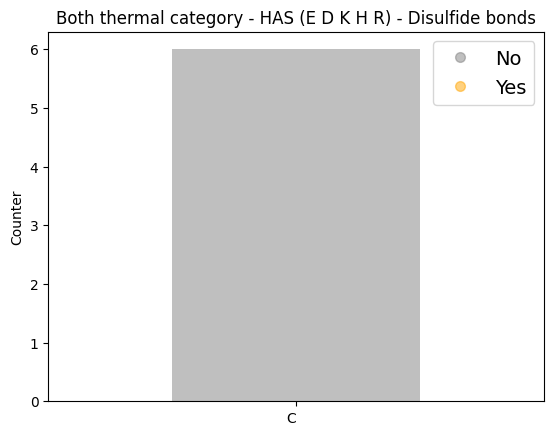

In [19]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=HAS_cumulative_disulfide.loc[HAS_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - HAS (E D K H R) - Disulfide bonds',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                markersize=14,linestyle='None'),
                Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                markersize=14,linestyle='None')
                ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
plt.savefig('img/SALT_BRIDGE_HAS_cumulative.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_HAS_cumulative.svg',format='svg', dpi=300, bbox_inches = "tight")

##### NO HAS

In [20]:
NOHAS_meso_disulfide_df

,nodisulfide,yesdisulfide,AA
0,378,0,L
1,407,0,A
2,329,0,G
3,312,0,V
4,234,0,E
5,203,0,S
6,256,0,I
7,245,0,K
8,193,0,R
9,267,0,D


In [21]:
NOHAS_thermo_disulfide_df

,nodisulfide,yesdisulfide,AA
0,344,0,L
1,373,0,A
2,306,0,G
3,345,0,V
4,298,0,E
5,155,0,S
6,222,0,I
7,227,0,K
8,202,0,R
9,196,0,D


In [22]:
NOHAS_cumulative_disulfide = NOHAS_meso_disulfide_df.add(NOHAS_thermo_disulfide_df, fill_value=0)
NOHAS_cumulative_disulfide['AA']=NOHAS_thermo_disulfide_df['AA']
NOHAS_cumulative_disulfide

,nodisulfide,yesdisulfide,AA
0,722,0,L
1,780,0,A
2,635,0,G
3,657,0,V
4,532,0,E
5,358,0,S
6,478,0,I
7,472,0,K
8,395,0,R
9,463,0,D


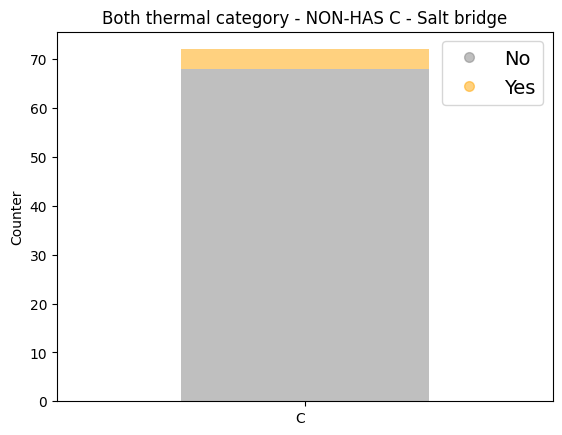

In [23]:
from matplotlib.colors import to_rgba
color_dict = {'nodisulfide': to_rgba('gray',0.5),'yesdisulfide': to_rgba('orange',0.5)}

ax=NOHAS_cumulative_disulfide.loc[NOHAS_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - NON-HAS C - Salt bridge',color=color_dict)
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Line2D([], [], marker='.', color= to_rgba('gray',0.5), label='No',
                        markersize=14,linestyle='None'),
                Line2D([], [], marker='.', color=to_rgba('orange',0.5), label='Yes',
                        markersize=14,linestyle='None')
                ]

plt.legend(handles=legend_elements, loc='best',fontsize=14,)
plt.savefig('img/SALT_BRIDGE_cumulative_nohas.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_cumulative_nohas.svg',format='svg', dpi=300, bbox_inches = "tight")

##### CONCAT

In [24]:
thermo_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,344,14,0,0
1,A,373,15,0,0
2,G,306,11,0,0
3,V,345,9,0,0
4,E,298,17,0,0
5,S,155,12,0,0
6,I,222,13,0,0
7,K,227,1,0,0
8,R,202,28,0,0
9,D,196,6,0,0


In [25]:
meso_concat_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,378,13,0,0
1,A,407,31,0,0
2,G,329,14,0,0
3,V,312,13,0,0
4,E,234,20,0,0
5,S,203,11,0,0
6,I,256,21,0,0
7,K,245,2,0,0
8,R,193,16,0,0
9,D,267,1,0,0


In [26]:
CONCAT_cumulative_disulfide = thermo_concat_disulfide.add(meso_concat_disulfide, fill_value=0)
CONCAT_cumulative_disulfide['AA']=NOHAS_thermo_disulfide_df['AA']
CONCAT_cumulative_disulfide

,AA,no_nohas,no_has,yes_nohas,yes_has
0,L,722,27,0,0
1,A,780,46,0,0
2,G,635,25,0,0
3,V,657,22,0,0
4,E,532,37,0,0
5,S,358,23,0,0
6,I,478,34,0,0
7,K,472,3,0,0
8,R,395,44,0,0
9,D,463,7,0,0


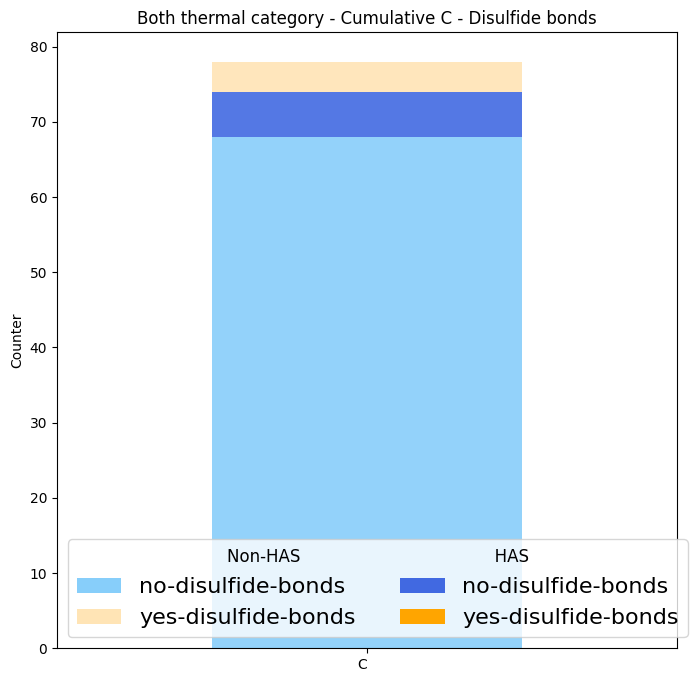

In [27]:
from matplotlib.colors import to_rgba
color_dict = {'no_nohas': to_rgba('lightskyblue',0.9),'yes_nohas': to_rgba('moccasin',0.9),'no_has': to_rgba('royalblue',0.9),'yes_has': to_rgba('orange',0.9)}

ax=CONCAT_cumulative_disulfide.loc[CONCAT_cumulative_disulfide['AA']== 'C'].plot.bar(x='AA',stacked=True, title='Both thermal category - Cumulative C - Disulfide bonds',color=color_dict,figsize=(8, 8))
plt.xticks(rotation=0, ha='right')
ax.set(xlabel=None)
ax.set(ylabel='Counter')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                Patch(facecolor='lightskyblue', label='no-disulfide-bonds', ),
                Patch(facecolor='moccasin', label='yes-disulfide-bonds'),
                Patch(facecolor='royalblue', label='no-disulfide-bonds'),
                Patch(facecolor='orange', label='yes-disulfide-bonds')
                ]

plt.legend(handles=legend_elements, loc='lower left', ncol=2, title_fontsize='large',title='Non-HAS                                     HAS',fontsize=24,prop={'size': 16} )
plt.savefig('img/SALT_BRIDGE_cumulative.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/SALT_BRIDGE_cumulative.svg',format='svg', dpi=300, bbox_inches = "tight")

# CUMULATIVE SASA ANALYSIS

In [28]:
#change order in plotting (core and then surface)
thermo_baseline_sasa_avgDict_exposition_plot_df=thermo_baseline_sasa_avgDict_exposition_plot_df[['core','surface']]

meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df[['core','surface']]

thermo_HAS_sasa_avgDict_exposition_plot_df=thermo_HAS_sasa_avgDict_exposition_plot_df[['core','surface']]

meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df[['core','surface']]


thermo_baseline_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
thermo_HAS_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

meso_baseline_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
meso_HAS_sasa_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

In [29]:
meso_HAS_sasa_avgDict_exposition_df

,L,A,G,V,E,S,I,K,R,D,T,P,N,Q,F,Y,M,H,C,W
core,0.846154,0.677419,0.5,0.769231,0.25,0.454545,0.809524,0.0,0.3125,0.0,0.571429,0.333333,0.75,1.0,0.818182,1.0,0.333333,0.333333,0.75,1.0
surface,0.153846,0.322581,0.5,0.230769,0.75,0.545455,0.190476,1.0,0.6875,1.0,0.428571,0.666667,0.25,0.0,0.181818,0.0,0.666667,0.666667,0.25,0.0


In [30]:
#forcing the order of the bars to be the same of the aa types category
aa_order=['R','K','H','D','E','S','T','N','Q','A','V','L','I','M','F','W','Y','G','P','C']
len(aa_order)
thermo_baseline_sasa_avgDict_exposition_df=thermo_baseline_sasa_avgDict_exposition_df[aa_order]
thermo_HAS_sasa_avgDict_exposition_df=thermo_HAS_sasa_avgDict_exposition_df[aa_order]
meso_baseline_sasa_avgDict_exposition_df=meso_baseline_sasa_avgDict_exposition_df[aa_order]
meso_HAS_sasa_avgDict_exposition_df=meso_HAS_sasa_avgDict_exposition_df[aa_order]
thermo_baseline_sasa_avgDict_exposition_plot_df=thermo_baseline_sasa_avgDict_exposition_plot_df.loc[aa_order]
thermo_HAS_sasa_avgDict_exposition_plot_df=thermo_HAS_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_baseline_sasa_avgDict_exposition_plot_df=meso_baseline_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_HAS_sasa_avgDict_exposition_plot_df=meso_HAS_sasa_avgDict_exposition_plot_df.loc[aa_order]
meso_HAS_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.3125,0.0,0.333333,0.0,0.25,0.454545,0.571429,0.75,1.0,0.677419,0.769231,0.846154,0.809524,0.333333,0.818182,1.0,1.0,0.5,0.333333,0.75
surface,0.6875,1.0,0.666667,1.0,0.75,0.545455,0.428571,0.25,0.0,0.322581,0.230769,0.153846,0.190476,0.666667,0.181818,0.0,0.0,0.5,0.666667,0.25


In [31]:
## INFO RECAP SUMMARY (needed only for the manuscript)
meso_recap=meso_baseline_sasa_avgDict_exposition_plot_df.copy(deep=True)
meso_recap['sum']=meso_recap[['core','surface']].sum(axis=1)
meso_HAS_recap=meso_HAS_sasa_avgDict_exposition_plot_df.copy(deep=True)
meso_HAS_recap['sum']=meso_HAS_recap[['core','surface']].sum(axis=1)
thermo_recap=thermo_baseline_sasa_avgDict_exposition_plot_df.copy(deep=True)
thermo_recap['sum']=thermo_recap[['core','surface']].sum(axis=1)
thermo_HAS_recap=thermo_HAS_sasa_avgDict_exposition_plot_df.copy(deep=True)
thermo_HAS_recap['sum']=thermo_HAS_recap[['core','surface']].sum(axis=1)

In [32]:
print(meso_recap)

       core   surface       sum
R  0.014282  0.035468  0.049750
K  0.008331  0.050464  0.058796
H  0.011188  0.012854  0.024042
D  0.016901  0.046894  0.063794
E  0.013568  0.046894  0.060462
S  0.025470  0.025470  0.050940
T  0.025708  0.019995  0.045703
N  0.014282  0.027612  0.041895
Q  0.008093  0.022138  0.030231
A  0.063318  0.040943  0.104261
V  0.060938  0.016425  0.077363
L  0.071174  0.021900  0.093073
I  0.052845  0.013092  0.065937
M  0.015711  0.007617  0.023328
F  0.022376  0.011426  0.033801
W  0.006427  0.002142  0.008569
Y  0.018567  0.007617  0.026184
G  0.041419  0.040229  0.081647
P  0.018329  0.029517  0.047846
C  0.009760  0.002618  0.012378


In [33]:
print(meso_HAS_recap)

       core   surface       sum
R  0.026455  0.058201  0.084656
K  0.000000  0.010582  0.010582
H  0.005291  0.010582  0.015873
D  0.000000  0.005291  0.005291
E  0.026455  0.079365  0.105820
S  0.026455  0.031746  0.058201
T  0.021164  0.015873  0.037037
N  0.015873  0.005291  0.021164
Q  0.005291  0.000000  0.005291
A  0.111111  0.052910  0.164021
V  0.052910  0.015873  0.068783
L  0.058201  0.010582  0.068783
I  0.089947  0.021164  0.111111
M  0.005291  0.010582  0.015873
F  0.047619  0.010582  0.058201
W  0.005291  0.000000  0.005291
Y  0.005291  0.000000  0.005291
G  0.037037  0.037037  0.074074
P  0.021164  0.042328  0.063492
C  0.015873  0.005291  0.021164


In [34]:
print(thermo_recap)

       core   surface       sum
R  0.013189  0.046289  0.059478
K  0.008275  0.050685  0.058960
H  0.011120  0.010344  0.021464
D  0.017326  0.034911  0.052237
E  0.014482  0.066977  0.081458
S  0.023015  0.020171  0.043186
T  0.028704  0.016292  0.044996
N  0.013447  0.020946  0.034394
Q  0.007241  0.015775  0.023015
A  0.066977  0.033359  0.100336
V  0.072925  0.018619  0.091544
L  0.073442  0.019136  0.092578
I  0.045513  0.015257  0.060771
M  0.016550  0.009568  0.026118
F  0.025084  0.009051  0.034135
W  0.007499  0.003362  0.010861
Y  0.013706  0.012413  0.026118
G  0.039824  0.042152  0.081976
P  0.019395  0.030256  0.049651
C  0.005431  0.001293  0.006724


In [35]:
sum(thermo_recap['sum'])

1.0000000000000002

In [36]:
print(thermo_HAS_recap)

       core   surface       sum
R  0.044586  0.121019  0.165605
K  0.000000  0.006369  0.006369
H  0.006369  0.025478  0.031847
D  0.012739  0.025478  0.038217
E  0.044586  0.063694  0.108280
S  0.044586  0.031847  0.076433
T  0.019108  0.006369  0.025478
N  0.006369  0.006369  0.012739
Q  0.000000  0.000000  0.000000
A  0.063694  0.025478  0.089172
V  0.057325  0.000000  0.057325
L  0.063694  0.025478  0.089172
I  0.063694  0.012739  0.076433
M  0.006369  0.006369  0.012739
F  0.031847  0.019108  0.050955
W  0.000000  0.000000  0.000000
Y  0.000000  0.006369  0.006369
G  0.044586  0.025478  0.070064
P  0.038217  0.031847  0.070064
C  0.012739  0.000000  0.012739


In [37]:
thermo_baseline_sasa_avgDict_exposition_plot_df

,core,surface
R,0.013189,0.046289
K,0.008275,0.050685
H,0.011120,0.010344
D,0.017326,0.034911
E,0.014482,0.066977
S,0.023015,0.020171
T,0.028704,0.016292
N,0.013447,0.020946
Q,0.007241,0.015775
A,0.066977,0.033359


/tmp/ipykernel_3283281/3951266919.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
/tmp/ipykernel_3283281/3951266919.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)


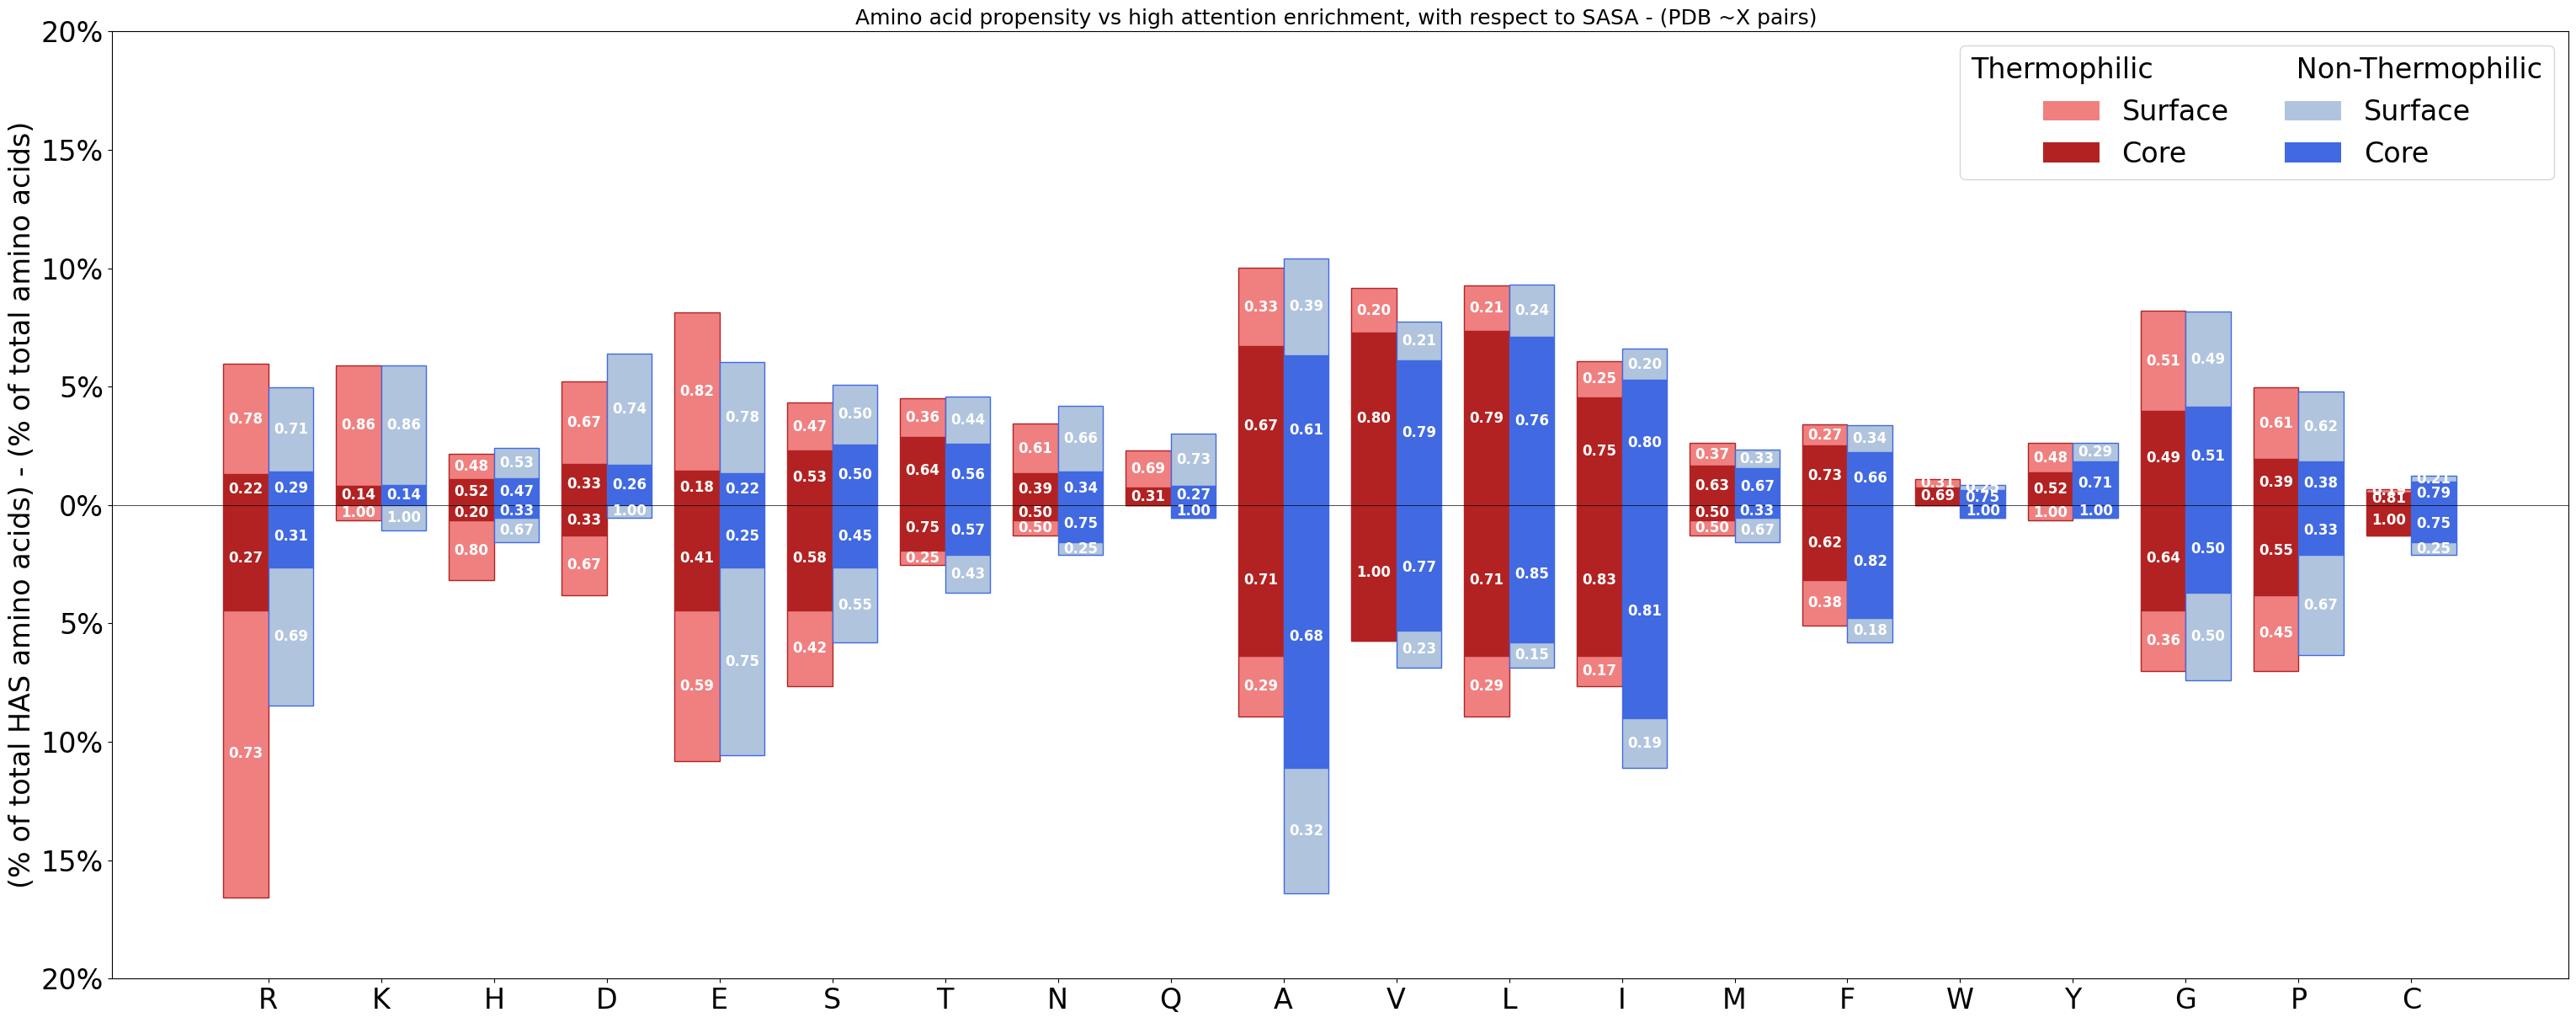

In [65]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(30, 15))

#baseline
thermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB ~X pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=24)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=12,label_type='center', color= 'white',weight='bold')

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.2f}".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=12,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)
plt.ylim([-0.20, 0.20])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=12,label_type='center',color= 'white',weight='bold')

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.2f}".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=12,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=24)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                  Patch(facecolor='firebrick',label='Core'),
                  Patch(facecolor='lightsteelblue',label='Surface'),
                  Patch(facecolor='royalblue',label='Core'),
                ]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=24,ncol=2, title='Thermophilic                Non-Thermophilic',title_fontsize=24)
plt.xticks(rotation=0,fontsize=24)
plt.yticks(rotation=0,fontsize=24)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=24)
plt.savefig('img/propensity_vs_HAS_SASA.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/propensity_vs_HAS_SASA.svg',format='svg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_3283281/561461925.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=28)
/tmp/ipykernel_3283281/561461925.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=28)


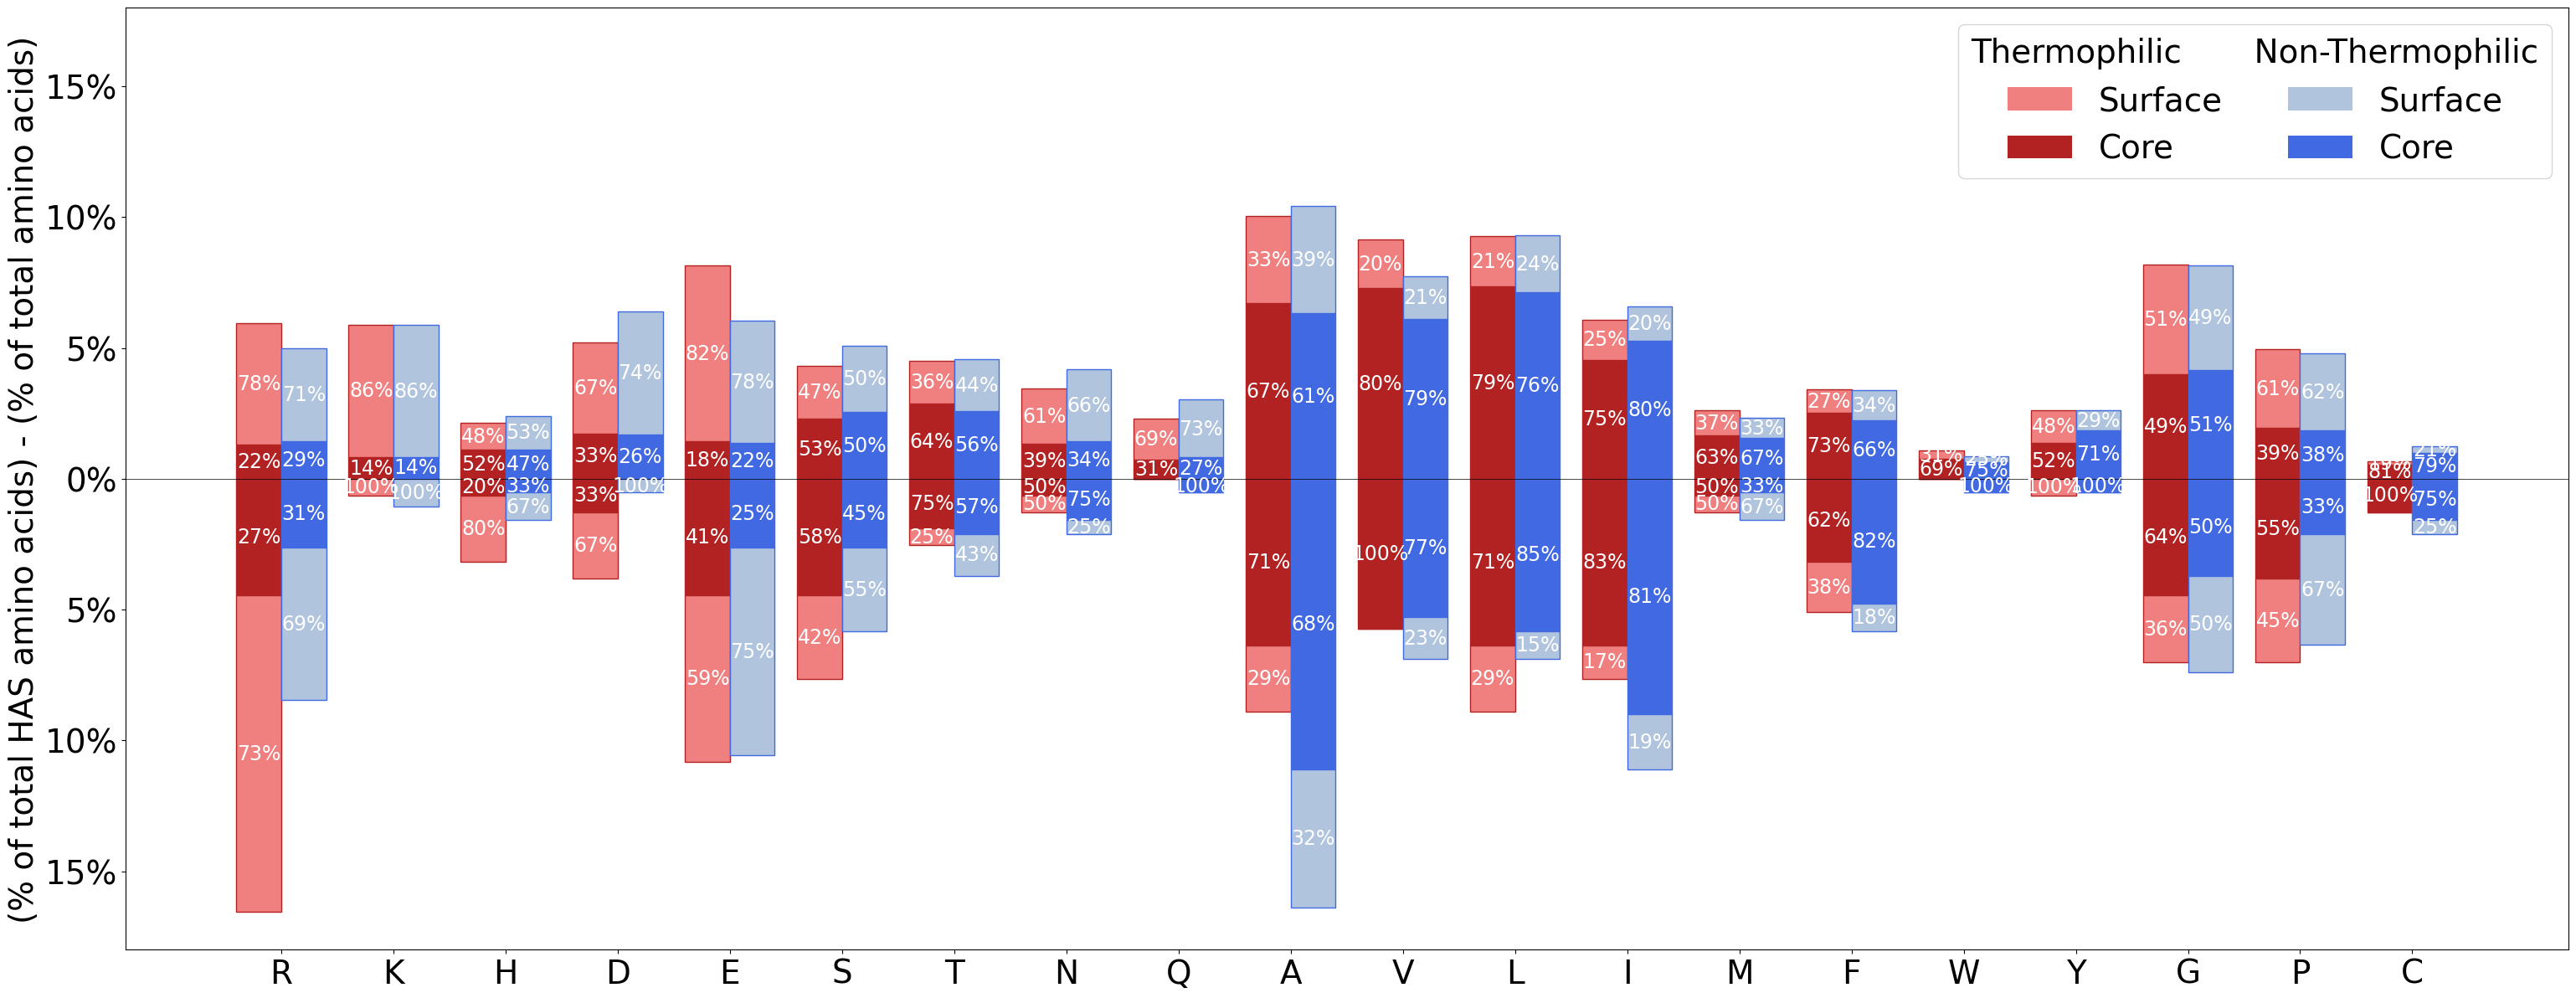

In [73]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(30, 15))

#baseline
thermo_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_sasa_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=-0.4,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_sasa_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.4,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


#plt.title('temberture Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB 17 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=28)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.0f}%".format(list(thermo_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]*100) if list(thermo_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=17,label_type='center', color= 'white',) #weight='bold'

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.0f}%".format(list(meso_baseline_sasa_avgDict_exposition_df.iloc[df_row])[v]*100) if list(meso_baseline_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=17,label_type='center',color= 'white',)

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=28)
plt.ylim([-0.18, 0.18])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.0f}%".format(list(thermo_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]*100) if list(thermo_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=17,label_type='center',color= 'white',)

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.0f}%".format(list(meso_HAS_sasa_avgDict_exposition_df.iloc[df_row])[v]*100) if list(meso_HAS_sasa_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=17,label_type='center',color= 'white',)

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=28)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                  Patch(facecolor='firebrick',label='Core'),
                  Patch(facecolor='lightsteelblue',label='Surface'),
                  Patch(facecolor='royalblue',label='Core'),
                  ]

# Create the figure

ax.legend(handles=legend_elements, loc='best',fontsize=28,ncol=2, title='Thermophilic       Non-Thermophilic',title_fontsize=28)
plt.xticks(rotation=0,fontsize=28)
plt.yticks(rotation=0,fontsize=28)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=28)
plt.savefig('img/propensity_vs_HAS_SASA_withdecimals.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/propensity_vs_HAS_SASA_withdecimals.svg',format='svg', dpi=300, bbox_inches = "tight")

In [40]:
thermo_baseline_sasa_avgDict_exposition_plot_df

,core,surface
R,0.013189,0.046289
K,0.008275,0.050685
H,0.011120,0.010344
D,0.017326,0.034911
E,0.014482,0.066977
S,0.023015,0.020171
T,0.028704,0.016292
N,0.013447,0.020946
Q,0.007241,0.015775
A,0.066977,0.033359


In [41]:
thermo_baseline_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.221739,0.140351,0.518072,0.331683,0.177778,0.532934,0.637931,0.390977,0.314607,0.667526,0.79661,0.793296,0.748936,0.633663,0.734848,0.690476,0.524752,0.485804,0.390625,0.807692
surface,0.778261,0.859649,0.481928,0.668317,0.822222,0.467066,0.362069,0.609023,0.685393,0.332474,0.20339,0.206704,0.251064,0.366337,0.265152,0.309524,0.475248,0.514196,0.609375,0.192308


In [42]:
meso_baseline_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.287081,0.1417,0.465347,0.264925,0.224409,0.5,0.5625,0.340909,0.267717,0.607306,0.787692,0.764706,0.801444,0.673469,0.661972,0.75,0.709091,0.507289,0.383085,0.788462
surface,0.712919,0.8583,0.534653,0.735075,0.775591,0.5,0.4375,0.659091,0.732283,0.392694,0.212308,0.235294,0.198556,0.326531,0.338028,0.25,0.290909,0.492711,0.616915,0.211538


In [43]:
thermo_HAS_sasa_avgDict_exposition_df
#meso_HAS_sasa_avgDict_exposition_df

,R,K,H,D,E,S,T,N,Q,A,V,L,I,M,F,W,Y,G,P,C
core,0.269231,0.0,0.2,0.333333,0.411765,0.583333,0.75,0.5,0,0.714286,1.0,0.714286,0.833333,0.5,0.625,0,0.0,0.636364,0.545455,1.0
surface,0.730769,1.0,0.8,0.666667,0.588235,0.416667,0.25,0.5,0,0.285714,0.0,0.285714,0.166667,0.5,0.375,0,1.0,0.363636,0.454545,0.0


# CUMULATIVE AA TYPES ANALYSIS

In [44]:
#change order in plotting (core and then surface)
thermo_baseline_aa_types_avgDict_exposition_plot_df=thermo_baseline_aa_types_avgDict_exposition_plot_df[['core','surface']]

meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df[['core','surface']]

thermo_HAS_aa_types_avgDict_exposition_plot_df=thermo_HAS_aa_types_avgDict_exposition_plot_df[['core','surface']]

meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df[['core','surface']]


thermo_baseline_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
thermo_HAS_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

meso_baseline_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)
meso_HAS_aa_types_avgDict_exposition_df.sort_index(axis=0,ascending=True,inplace=True)

In [45]:
# removing special amino acids in the plot
meso_HAS_aa_types_avgDict_exposition_df=meso_HAS_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_baseline_aa_types_avgDict_exposition_df=meso_baseline_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_baseline_aa_types_avgDict_exposition_df=thermo_baseline_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_HAS_aa_types_avgDict_exposition_df=thermo_HAS_aa_types_avgDict_exposition_df[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]

In [46]:
thermo_baseline_aa_types_avgDict_exposition_plot_df=thermo_baseline_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_baseline_aa_types_avgDict_exposition_plot_df=meso_baseline_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
thermo_HAS_aa_types_avgDict_exposition_plot_df=thermo_HAS_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]
meso_HAS_aa_types_avgDict_exposition_plot_df=meso_HAS_aa_types_avgDict_exposition_plot_df.loc[['pos_charged_aa', 'neg_charged_aa', 'uncharged_polar_aa','hydrophobic_aa', 'hydrophobic_aa_withrings']]

In [47]:
## INFO RECAP SUMMARY (needed only for the manuscript)
meso_recap=meso_baseline_aa_types_avgDict_exposition_plot_df.copy(deep=True)
meso_recap['sum']=meso_recap[['core','surface']].sum(axis=1)
meso_HAS_recap=meso_HAS_aa_types_avgDict_exposition_plot_df.copy(deep=True)
meso_HAS_recap['sum']=meso_HAS_recap[['core','surface']].sum(axis=1)
thermo_recap=thermo_baseline_aa_types_avgDict_exposition_plot_df.copy(deep=True)
thermo_recap['sum']=thermo_recap[['core','surface']].sum(axis=1)
thermo_HAS_recap=thermo_HAS_aa_types_avgDict_exposition_plot_df.copy(deep=True)
thermo_HAS_recap['sum']=thermo_HAS_recap[['core','surface']].sum(axis=1)

In [48]:
meso_recap

,core,surface,sum
pos_charged_aa,0.033801,0.098786,0.132587
neg_charged_aa,0.030469,0.093787,0.124256
uncharged_polar_aa,0.073554,0.095215,0.168769
hydrophobic_aa,0.263985,0.099976,0.363961
hydrophobic_aa_withrings,0.047370,0.021185,0.068555


In [49]:
meso_HAS_recap

,core,surface,sum
pos_charged_aa,0.031746,0.079365,0.111111
neg_charged_aa,0.026455,0.084656,0.111111
uncharged_polar_aa,0.068783,0.052910,0.121693
hydrophobic_aa,0.317460,0.111111,0.428571
hydrophobic_aa_withrings,0.058201,0.010582,0.068783


In [50]:
thermo_recap

,core,surface,sum
pos_charged_aa,0.032583,0.107318,0.139902
neg_charged_aa,0.031808,0.101888,0.133695
uncharged_polar_aa,0.072408,0.073183,0.145591
hydrophobic_aa,0.275407,0.095940,0.371347
hydrophobic_aa_withrings,0.046289,0.024825,0.071115


In [51]:
thermo_HAS_recap

,core,surface,sum
pos_charged_aa,0.050955,0.152866,0.203822
neg_charged_aa,0.057325,0.089172,0.146497
uncharged_polar_aa,0.070064,0.044586,0.114650
hydrophobic_aa,0.254777,0.070064,0.324841
hydrophobic_aa_withrings,0.031847,0.025478,0.057325


/tmp/ipykernel_3283281/3747803597.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
/tmp/ipykernel_3283281/3747803597.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)


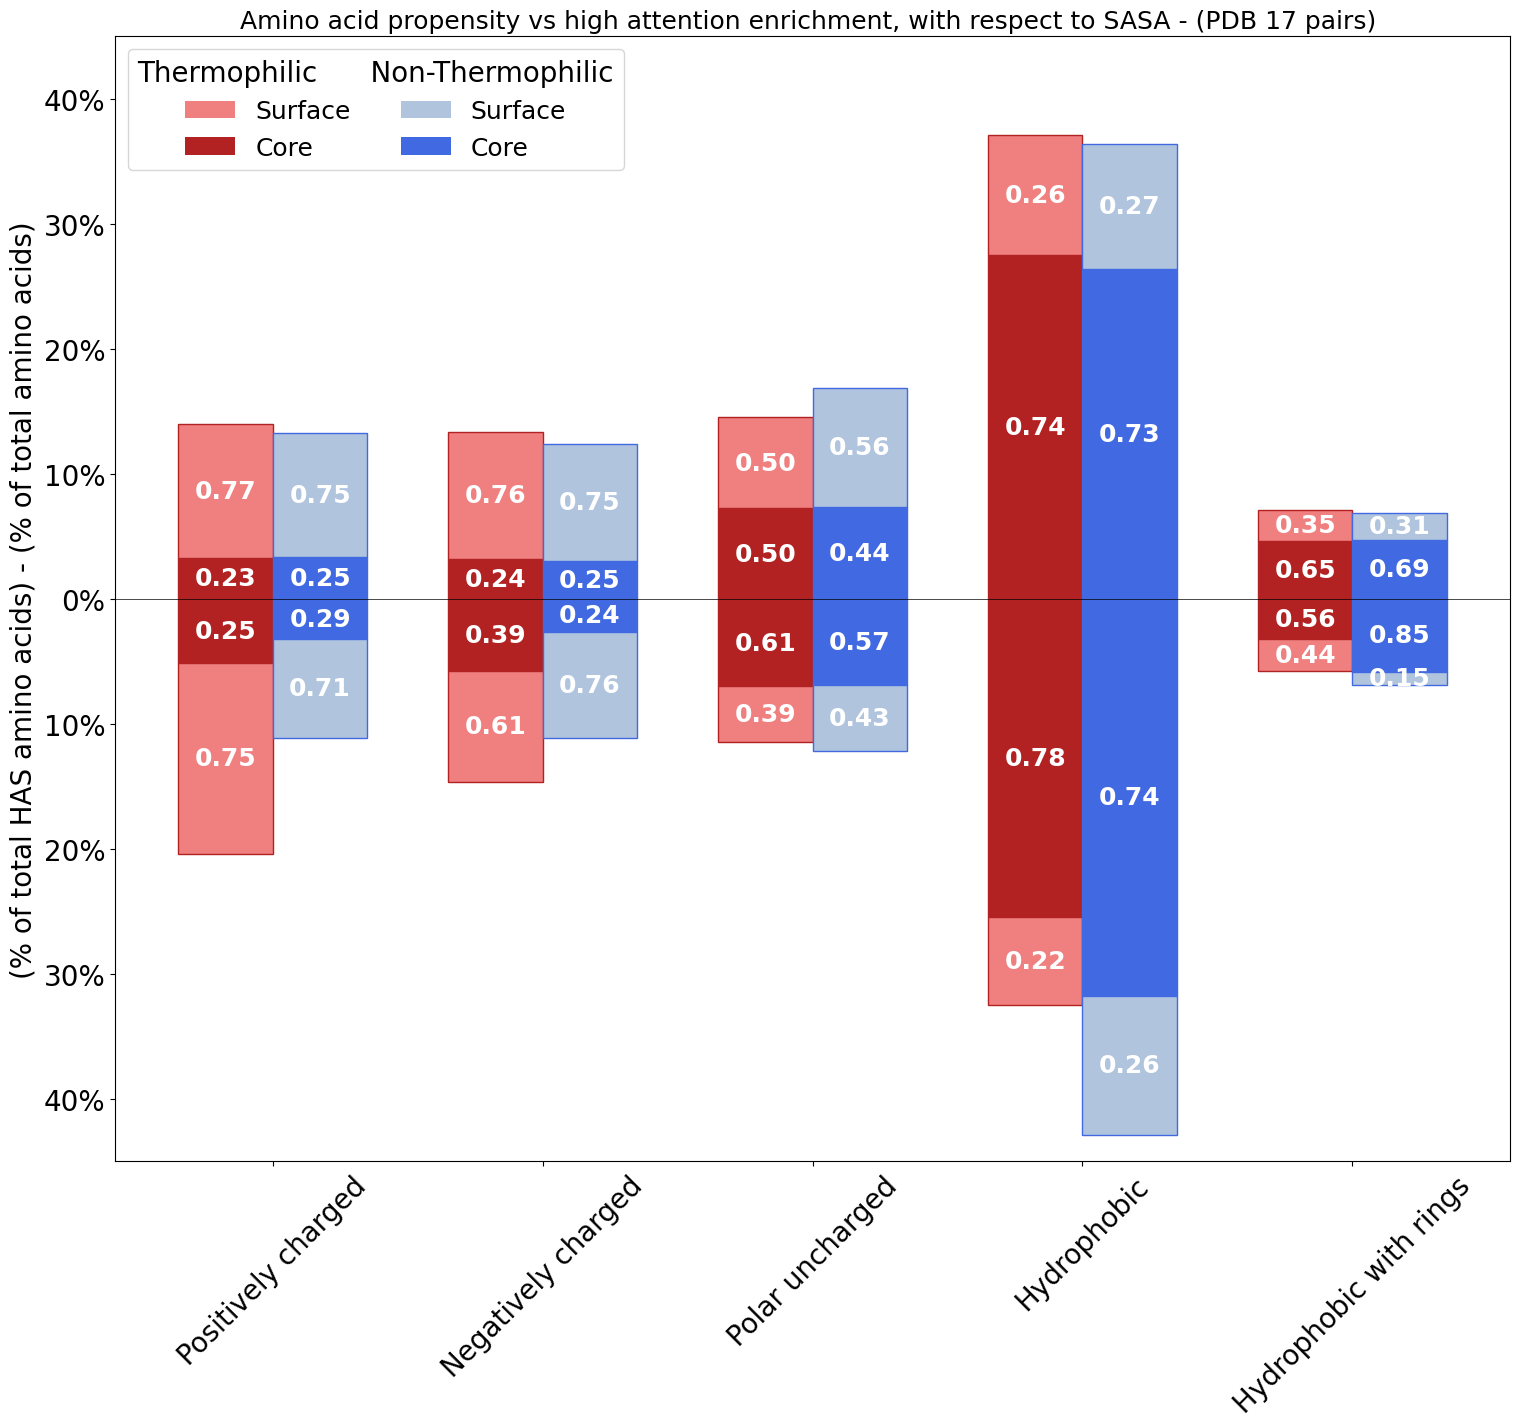

In [52]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(15, 15))

#baseline
thermo_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar',  stacked=True,width=-0.35,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.35,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar',  stacked=True,width=-0.35,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.35,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


#plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB 17 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=18)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=18,label_type='center', color= 'white',weight='bold')

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.2f}".format(list(meso_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=18,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
plt.ylim([-0.45, 0.45])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.2f}".format(list(thermo_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(thermo_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=18,label_type='center',color= 'white',weight='bold')

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.2f}".format(list(meso_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]) if list(meso_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=18,label_type='center',color= 'white',weight='bold')

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)

#ax.set_xticklabels(['Hydrophobic amino acids','Polar amino acids','Charged amino acids'])
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                  Patch(facecolor='firebrick',label='Core'),
                  Patch(facecolor='lightsteelblue',label='Surface'),
                  Patch(facecolor='royalblue',label='Core'),
                ]

ax.legend(handles=legend_elements, loc='best',fontsize=18,ncol=2, title='Thermophilic      Non-Thermophilic',title_fontsize=20)
#labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings','Glycine','Proline','Cysteine')
labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings')
x_pos = np.arange(len(labels))
ax.set_xticklabels(labels)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=0,fontsize=20)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=20)
plt.savefig('img/propensity_vs_HAS_SASA_aatypes.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/propensity_vs_HAS_SASA_aatypes.svg',format='svg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_3283281/3915057550.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
/tmp/ipykernel_3283281/3915057550.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)


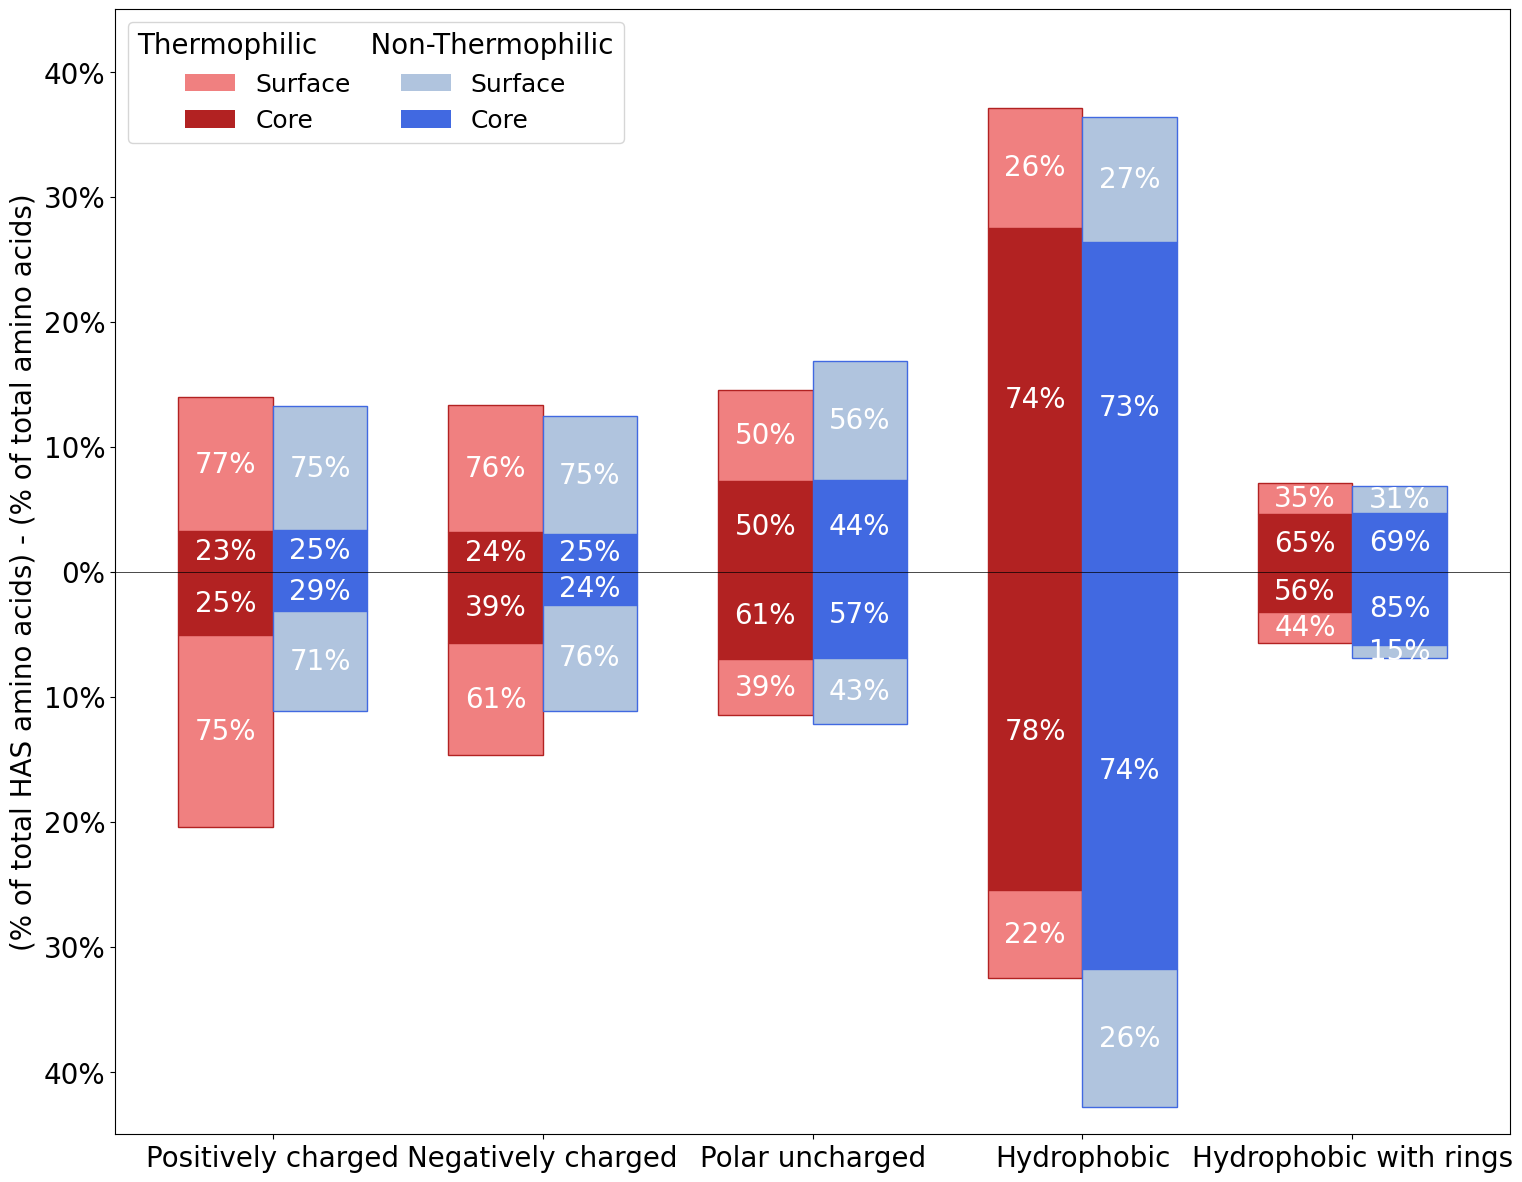

In [78]:
## BASELINE VS HAS -- ALTERNATIVE COLOR
fig, ax = plt.subplots(figsize=(15, 15))

#baseline
thermo_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar',  stacked=True,width=-0.35,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
meso_baseline_aa_types_avgDict_exposition_plot_df.plot(kind='bar', stacked=True,width=0.35,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue'])
#HAS
(thermo_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar',  stacked=True,width=-0.35,align='edge',ax=ax,edgecolor='firebrick',color=['firebrick','lightcoral',],legend=False)
(meso_HAS_aa_types_avgDict_exposition_plot_df* -1).plot(kind='bar', stacked=True,width=0.35,align='edge',ax=ax,legend=False,edgecolor='royalblue',color=['royalblue','lightsteelblue',],)


#plt.title('Amino acid propensity vs high attention enrichment, with respect to SASA - (PDB 17 pairs) ',fontsize=18)
ax.autoscale(tight=False)
ax.axhline(0, color='black', linewidth=0.5) #adding x ax

# Formatting x labels
plt.xticks(rotation=0,fontsize=18)
plt.tight_layout()
ax.use_sticky_edges = False


## add annotations
df_row=0
#up plot
for c in ax.containers[0:2]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.0f}%".format(list(thermo_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]*100) if list(thermo_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=20,label_type='center', color= 'white',)

df_row=0
for c in ax.containers[2:4]:
  labels = ["{:.0f}%".format(list(meso_baseline_aa_types_avgDict_exposition_df.iloc[df_row])[v]*100) if list(meso_baseline_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=20,label_type='center',color= 'white',)

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)
plt.ylim([-0.45, 0.45])

plt.subplots_adjust(top=0.85,bottom=0.10)

## add annotations
df_row=0
#down plot
for c in ax.containers[4:6]:
  #[word for sentence in text for word in sentence]
  labels = ["{:.0f}%".format(list(thermo_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]*100) if list(thermo_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  #print(labels)
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=20,label_type='center',color= 'white',)

df_row=0
for c in ax.containers[6:8]:
  labels = ["{:.0f}%".format(list(meso_HAS_aa_types_avgDict_exposition_df.iloc[df_row])[v]*100) if list(meso_HAS_aa_types_avgDict_exposition_df .iloc[df_row])[v] > 0.09 else '' for v in range(0,len(c)) ]
  df_row+=1
  ax.bar_label(c, labels=labels, fontsize=20,label_type='center',color= 'white',) #weight='bold'

ticks =  ax.get_yticks()
ax.set_yticklabels([("{0:.0%}".format(abs(tick))) for tick in ticks],fontsize=18)

#ax.set_xticklabels(['Hydrophobic amino acids','Polar amino acids','Charged amino acids'])
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightcoral',label='Surface'),
                  Patch(facecolor='firebrick',label='Core'),
                  Patch(facecolor='lightsteelblue',label='Surface'),
                  Patch(facecolor='royalblue',label='Core'),
                ]

ax.legend(handles=legend_elements, loc='best',fontsize=18,ncol=2, title='Thermophilic      Non-Thermophilic',title_fontsize=20)
#labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings','Glycine','Proline','Cysteine')
labels = ('Positively charged', 'Negatively charged', 'Polar uncharged', 'Hydrophobic', 'Hydrophobic with rings')
x_pos = np.arange(len(labels))
ax.set_xticklabels(labels)
plt.xticks(rotation=0,fontsize=20)
plt.yticks(rotation=0,fontsize=20)

plt.ylabel("(% of total HAS amino acids) - (% of total amino acids)",fontsize=20)
plt.savefig('img/propensity_vs_HAS_SASA_aatypes.png',dpi=300, bbox_inches = "tight")
plt.savefig('img/propensity_vs_HAS_SASA_aatypes.svg',format='svg', dpi=300, bbox_inches = "tight")

# APPENDIX : ATT_SCORE VS SASA FOR ALL THE THERMO AND ALL THE MESO CONCATENATED

In [53]:
def biopython_sasa_VS_attention(data,sasa_on_pdb=False,att_on_pdb=False):
  '''How to read biopython structure where a is the chain
  for resi_ind, resi in enumerate(struct[0]['A'].get_residues()):

    res_id = resi.get_full_id()
    print(res_id)
    print(res_id[3])
    resi_name=resi.get_resname()
    print(resi_name)'''
  #%shell
  #!gunzip *.gz

  from Bio.PDB import MMCIFParser,PDBParser
  from Bio.PDB.Residue import Residue
  from Bio.PDB.Atom import Atom
  from Bio.PDB.Chain import Chain
  from Bio.PDB.Structure import Structure
  from Bio.PDB.Model import Model
  from Bio.PDB.PDBList import PDBList
  from Bio.PDB.SASA import ShrakeRupley
  from Bio.PDB.DSSP import DSSP
  import Bio.PDB.PDBExceptions
  import prody
  from collections import OrderedDictmeso_baseline_aa_types_avgDict_exposition_plot_df

  n_pdbs_processed=0
  all_df_score=[]

  for ind,prot in tqdm(data.iterrows()):

    !rm -r *.pdb
    #!rm -r *.gz

    id = prot.PDB_ID
    seq_mask =  (np.around(np.fromstring(prot.SEQ_MASK[1:-1], sep=' ')).astype(int)).tolist()
    seq_complete = prot.COMPLETE_SEQ
    seq_complete_aa=list(seq_complete) #reading aa per aa

    try:
      # 1. reading pdb
      pdb_id,chain=id.rsplit('_')
      pdb = prody.parsePDB(pdb_id,chain=chain)
      #prot = pdb.select('protein')
      pdb = pdb.select(f"protein and resid 1 to {pdb.select('pdbter').getResnums()[0]}")


      print('')
      print(f'Reading {pdb_id} with chain {chain}')
      print('')

      prody_seq=pdb.ca.getSequence()

      ####### SASA SCORE ##########

      try:
        mse = pdb.select('resname MSE')
        mse.setResnames(["MET"]*len(mse))
      except AttributeError:
        pass

      prody.writePDB(pdb_id+'_edit.pdb', pdb)
      parser = PDBParser()
      structure = parser.get_structure('pdb', pdb_id+'_edit.pdb')

      try:
        model = structure[0]
        dssp = DSSP(model, pdb_id+'_edit.pdb', dssp="dssp") #dssp='mkdssp'
        dssp_out = list(dssp)
        chain_dss= [lis for lis in dssp_out if lis]
        res_name = [lis[1] for lis in dssp_out]
        sasa_score = [lis[3] for lis in dssp_out]

        prody_seq=pdb.ca.getSequence()
        #print(prody_seq)

        #extract all the res id in the pdb
        res_id=pdb.ca.getResnums()

        #check
        if len(list(prody_seq)) != len(sasa_score):
          print('--Error: length prody sequence and length sasa score are different')
          continue
        if len(seq_complete_aa) != len(seq_mask):
          print('--Error: length complete sequence and length seq masks are different')
          break
        if len(list(prody_seq)) != len(list(seq_mask[i] for i in seq_mask if i == 1 )):
          print('--Error: length prody sequence and length of mask == 1 are different')
          break
        if len(list(res_id)) != len(list(seq_mask[i] for i in seq_mask if i == 1 )):
          print('--Error: length res ids and length of mask == 1 are different')
          break

        ### RUN THE MODEL ON SEQ_COMPLETE AND EXTRACT THE SASA SCORE ONLY FOR THE PARTIAL SEQUENCE FOR WHICH WE HAVE THE STRUCTURE (mask ==1)

        # computing attention respect to cls token
        df_all_vs_all,att_to_cls,df_att_to_cls_exp = attention_score_to_cls_token_and_to_all(seq_complete.replace('',' '),model_bert)
        att_to_cls = att_to_cls.drop(labels = ['[CLS]','[SEP]'])

        # ATTENTION SCORE SOFTMAX SCALING + MAX NORMALIZATION
        from scipy.special import softmax
        att_score_softmax = softmax(att_to_cls)
        att_score_softmax_maxnorm = att_score_softmax / max(att_score_softmax)

        # creating all info df
        df = pd.DataFrame({'att_score':att_score_softmax_maxnorm,'seq_mask':seq_mask})

        print(df)
        # adding the sasa score only at aa with mask 1 (available in the pdb structure)
        df['sasa_score']=sasa_mask_selection(df['seq_mask'],sasa_score)
        #adding a res id column only at aa with mask 1 (available in the pdb structure)
        df['res_id']=sasa_mask_selection(df['seq_mask'],res_id)


        # high attention/outlier detection using IQR method
        HAS_df=find_high_outliers_IQR(df) # only high attention as outlier
        HAS_indexes=list(HAS_df.index)
        print(HAS_df)
        for i in HAS_indexes:
          #print(i)  # adding a col where True means that the aa is an high attention one
          df.loc[i, 'HAS'] = "True"

        df['HAS'].fillna('False', inplace=True)

        #print(df[df['HAS']=='False'])
        df = df.set_index([seq_complete_aa]) #res_name is for the prody seq
        # sub df containing only the masked == 1 aminoacid to perform the b-factor analysis (1:1)
        df_score=df[df['seq_mask']==1]
        print('ciao')
        print(df_score)
        all_df_score.append(df_score)

        # using the b-field as coloring method to check the threshold of sasa score (buried-not buried)
        if sasa_on_pdb==True:
          sasa_buried_not_buried=sasa_buried_not_buried_map(sasa_score)
          if len(pdb.ca.getBetas()) != len(sasa_buried_not_buried):
            print('--ERROR length betas is different from the length of sasa score')
            break
          pdb.setBetas(0)
          pdb.ca.setBetas(sasa_buried_not_buried)
          prody.writePDB((pdb_id+'_'+chain+'_sasa_as_betas.pdb'),pdb.select('ca'))

        # using the b-field as coloring method to plot the attention score only in the aa present in the pdb while the score is obtained on the complete sequence
        if att_on_pdb==True:
          att_for_masked_aa = df[df['seq_mask'] == 1]['att_score'] * 100000
          if len(pdb.ca.getBetas()) != len(att_for_masked_aa):
            print('--ERROR length betas is different from the length of attention score')
            break
          pdb.setBetas(0)
          pdb.ca.setBetas(att_for_masked_aa)
          prody.writePDB((pdb_id+'_'+chain+'_att_as_betas.pdb'),pdb.select('ca'))
          if len(att_for_masked_aa) != len(prody_seq):
            print('--ERROR inconsistency in the attention score length for masked aa and len of masked aa sequence (prody_seq')
            break


        n_pdbs_processed+=1

      except (Bio.PDB.PDBExceptions.PDBException,Exception):
        pass
    except KeyError:
      pass
    except ValueError:
      pass

  return all_df_score,n_pdbs_processed

In [54]:
#data_sample=pd.concat([pdb_meso.sample(10,random_state=42),pdb_thermo.sample(10,random_state=42)])
data_sample=pd.concat([pdb_meso,pdb_thermo])
data_sample

,PDB_ID,COMPLETE_SEQ,SEQ_MASK,LABEL,CLS_SCORE
0,6BLB_A,AIRPLKLADYIGQPSVREQMELFIHAARGRQEALDHTLIFGPPGLG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.003616
1,2Z1U_A,TLLLDYGSGGRASHRLISDLFLRHFDNPILGTLNDAARLDLTGPLA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.218385
2,1UP0_A,ANPLAGKPFYVDPASAAMVAARNANPPNAELTSVANTPQSYWLDQA...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.026884
3,6K21_A,SYNNIPAGKDAPNDIYVIIEIPANAAPIKYEIDKDSDALFVDRFMG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002263
4,3VML_A,SSYQIAVLAGDGIGPEVMAEARKVLKAVEARFGLNIEYTEYDVGGI...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.001266
5,1LLC_A,ASITDKDHQKVILVGDGAVGSSYAFAMVLQGIAQEIGIVDIFKDKT...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.016418
6,1RTV_A,MKATRLAIPDVILFEPRVFGDDRGFFFESYNQRAFEEACGHPVSFV...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.193056
7,4P3V_A,MNKSQLIDKIAAGADISKAAAGRALDAIIASVTESLKEGDDVALVG...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.002748
8,2Z2I_A,MAEPLLVVGLGNPGANYARTRHNLGFVVADLLAARLGAKFKAHKRS...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.007980
9,1DXH_A,AFNMHNRNLLSLMHHSTRELRYLLDLSRDLKRAKYTGTEQQHLKRK...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...,0,0.070078


In [55]:
few_df_score,n_pdbs_processed = biopython_sasa_VS_attention(data_sample)

ImportError: cannot import name 'OrderedDictmeso_baseline_aa_types_avgDict_exposition_plot_df' from 'collections' (/home/rodelc/anaconda3/envs/adapters_lib/lib/python3.9/collections/__init__.py)

In [ ]:
n_pdbs_processed

In [ ]:
len(pdb_thermo)

In [ ]:
len(pdb_meso)

In [ ]:
few_df_score[0][few_df_score[0]['HAS']== 'True']

In [ ]:
'''import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.2)}

for df in few_df_score:
  sns.scatterplot(x='att_score',y='sasa_score',hue='HAS',data=df,palette=color_dict)

plt.xlabel('Softmax-max normalized attention score',fontsize=16)
plt.ylabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.png')
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.svg')
plt.title('Mixed')
plt.show()'''

In [ ]:
'''import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.2)}

for df in few_df_score:
  sns.scatterplot(x='sasa_score',y='att_score',hue='HAS',data=df,palette=color_dict)

plt.ylabel('Softmax-max normalized attention score',fontsize=16)
plt.xlabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.png')
plt.savefig('thermo_norm_bfactor_vs_softmax_maxnorm_attscore.svg')
plt.title('Mixed')
plt.show()'''

In [ ]:
df_concat=pd.concat(few_df_score)
df_concat=df_concat[df_concat["sasa_score"]!='NA']
df_concat

In [ ]:
df_concat[df_concat['HAS']=='True'] #3344

In [ ]:
# JOIN PLOT for all the 133 PAIRS
import seaborn as sns
from matplotlib.colors import to_rgba
plt.figure(figsize=(14, 8))
color_dict = {'True': to_rgba('red',0.8),'False': to_rgba('gray',0.4)}

sns.jointplot(x='att_score',y='sasa_score',hue='HAS',thresh=0.01,kind='kde',data=df_concat,palette=color_dict,height=10,marginal_kws={'common_norm':False, 'alpha':0.4,'fill': False})

plt.xlabel('Softmax-max normalized attention score',fontsize=16)
plt.ylabel('Sasa score',fontsize=16)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
                  Line2D([], [], marker='.', color='red', label='High-attention',
                          markersize=14,linestyle='None'),
                  Line2D([], [], marker='.', color='gray', label='Non high-attention',
                          markersize=14,linestyle='None')
                  ]

plt.legend(handles=legend_elements, loc='upper right',fontsize=16,)
plt.savefig('thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.svg')
plt.savefig('thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.png')

plt.suptitle('Thermo and Non-thermo - ~130 PDB pairs ')
plt.show()

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

# to edit
#!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.png
#!gupload --to '1_eEVbOWgOg2aOLcf32D6VSU5cAYNYes2' thermo_non_thermo_norm_bfactor_vs_softmax_maxnorm_attscore_marginals.svg